### Computing and Binning Radial Distances between Sat-Host (PAI), and Time of Infall:

---


In [1]:
import numpy as np
import pandas as pd
from base import *
import tqdm as tqdm

from scipy import interpolate

In [2]:
# pulling data on all tracked gas of selected satellites into df.
allGas = pd.DataFrame()

keys = ['h148_12','h148_27','h148_34','h148_38','h148_55','h148_65','h148_249',
        'h148_251','h148_282','h229_14','h229_18','h229_20','h229_22',
        'h229_49','h242_21','h242_38','h242_69','h329_29','h329_117']

for i,key in enumerate(keys):
    i += 1
    allGas1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/all_particles.hdf5',
                          key=key)
    allGas1['key'] = key
    allGas = pd.concat([allGas, allGas1])

In [3]:
### point at infall calculation ###
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2 
                            + (gas['host_Yc'] - gas['sat_Yc'])**2 
                            + (gas['host_Zc'] - gas['sat_Zc'])**2 
                           )/ gas['hostRvir']
                   )

### interpolation for approximating time of infall ###
@pynbody.derived_array
def infall(gas, key):
    gas1 = gas[gas.key==key]  # will get errors if not using array of all gas.
    gas1 = gas1.sort_values(by=['time'])
    
    pai1 = np.unique(gas1.pai)
    time = np.unique(gas1.time)

    f = interpolate.interp1d(pai1, time, fill_value='extrapolate')
    
    return f(1)  # finding time when at 1 Rvir of host. 

#### Generating HDF5 of satellite data:

In [5]:
from pickle_prot import pickle_protocol

allGas['host'] = [x[:4] for x in np.array(allGas['key'])]
allGas['sat'] = [x[5:] for x in np.array(allGas['key'])]
allGas['pai'] = pai(allGas)

keys = get_keys()

for key in tqdm.tqdm(keys):
    gas = allGas[allGas.key==key]
    
    time, uniq_ind = np.unique(gas.time, return_index = True)
    gas = gas.iloc[uniq_ind]
    
    t_start = [gas.time.max()] * len(time)
    t_infall = [infall(gas, key)] * len(time)
    key1 = [key] * len(time)
    
    satdat = pd.DataFrame(np.array([key1, time, gas.pai, t_start,
                                    t_infall]).T,
                          columns=['key', 'time', 'pai', 't_start', 't_infall'])
    
    # saving to hdf.
    filepath = f'{rootPath}Stellar_Feedback_Code/SNeData/satdat.hdf5'
    with pickle_protocol(4):
        satdat.to_hdf(filepath, key=key)

100%|███████████████████████████████████████████| 19/19 [00:05<00:00,  3.55it/s]


## Use this cell in your notebook to import satellite data:

In [4]:
keys = ['h148_12','h148_27','h148_34','h148_38','h148_55','h148_65','h148_249',
        'h148_251','h148_282','h229_14','h229_18','h229_20','h229_22',
        'h229_49','h242_21','h242_38','h242_69','h329_29','h329_117']

satdat = pd.DataFrame([])

for key in keys:
    satdat1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/satdat.hdf5',
                          key=key)
    satdat1 = satdat1.astype({'time': float, 'pai': float, 't_start': float,
                              't_infall': float})
    satdat1['key'] = key
    satdat = pd.concat([satdat, satdat1])

In [5]:
satdat

,key,time,pai,t_start,t_infall
0,h148_12,7.336092,1.700105,13.800797,8.529619
1,h148_12,7.767072,1.191512,13.800797,8.529619
2,h148_12,8.198053,0.689575,13.800797,8.529619
3,h148_12,8.608831,0.527208,13.800797,8.529619
4,h148_12,9.060013,0.755363,13.800797,8.529619
...,...,...,...,...,...
33,h329_117,12.615601,1.264641,13.800797,7.071061
34,h329_117,12.938837,1.132123,13.800797,7.071061
35,h329_117,13.262072,0.963317,13.800797,7.071061
36,h329_117,13.585307,0.762873,13.800797,7.071061


In [133]:
dat = satdat[satdat.key=='h242_69']
# dat[['time','pai']]

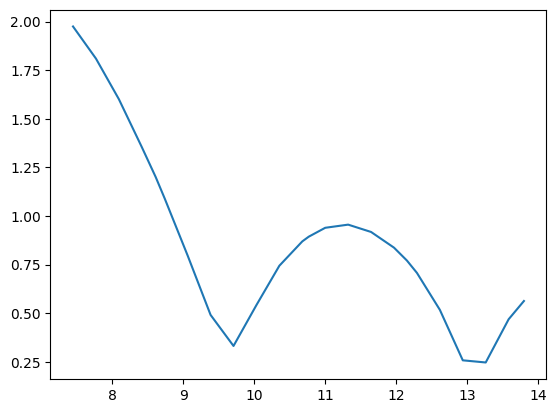

In [134]:
plt.plot(dat.time, dat.pai)
plt.show()